In [1]:
import torch
import numpy as np
import os
import pandas as pd
import datasets

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090 Ti'

In [3]:
torch.cuda.device_count()

1

In [4]:
%matplotlib inline
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [5]:
transform_train = transforms.Compose([
    
    transforms.Resize((1024, 1024)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.FiveCrop(size=(450, 450)),
    transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop) for crop in crops])),
    transforms.RandomRotation((0, 180)),
    transforms.Resize((224, 224)),
])
transform_val = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.CenterCrop(size=(900, 900)),
    transforms.FiveCrop(size=(450, 450)),
    transforms.Lambda(lambda crops: torch.stack([transforms.PILToTensor()(crop) for crop in crops])),
    transforms.Resize((224, 224)),
])
train_folder = ImageFolder(root="train")
val_folder = ImageFolder(root="train")
train_set, val_set = torch.utils.data.random_split(train_folder, [0.8,0.2])
val_set.dataset = val_folder
train_set.dataset.transform=transform_train
val_set.dataset.transform=transform_val


In [6]:
# Create a DataLoader
batch_size = int(32)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


C:\Users\mettn\miniconda3\envs\pt\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


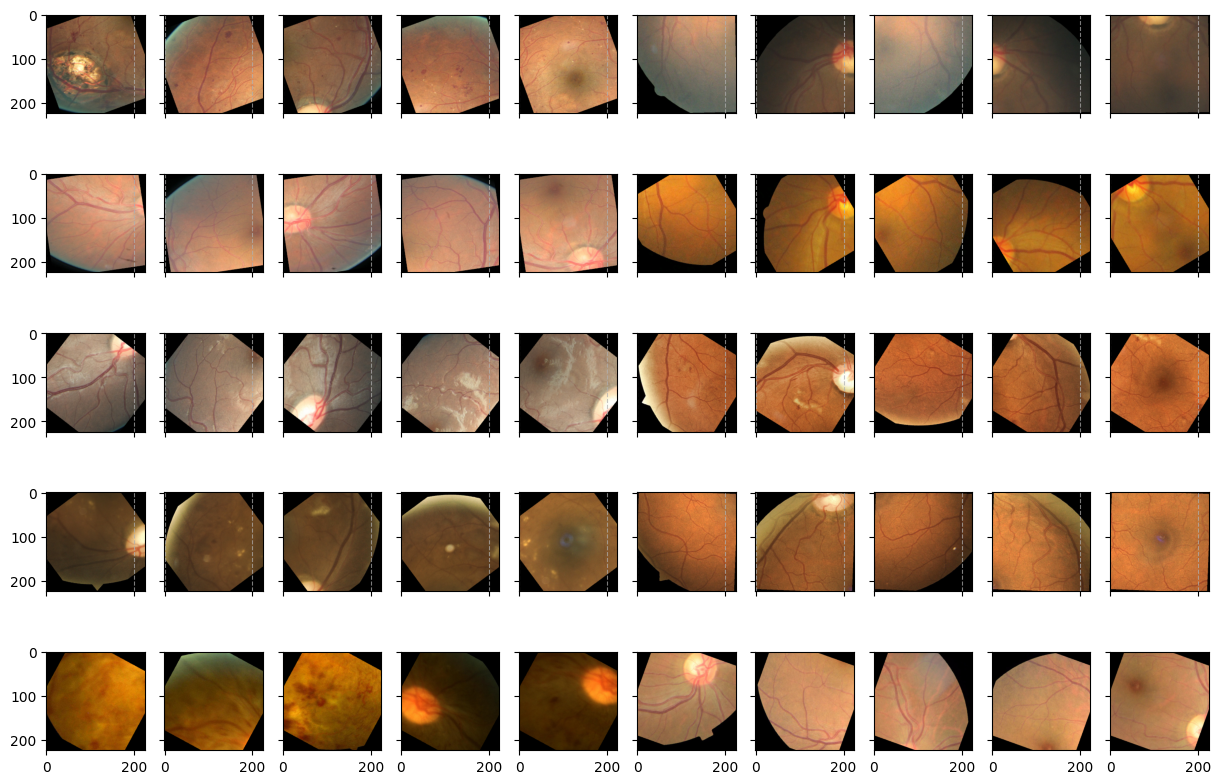

In [7]:
figs, axs = plt.subplots(5,10, figsize=(15, 10))
for col in range(1,10):
    for ax in axs[:, col]:
        ax.yaxis.set_ticklabels([])

# Set x-grid only for the lower subplots
for row in range(4):
    for ax in axs[row, :]:
        ax.xaxis.set_ticklabels([])
        ax.xaxis.grid(True, linestyle='--', alpha=0.7)
axs=axs.flatten()

for i, (inputs, labels) in enumerate(train_loader):
    if i < 1:
        for j in range(50):
            bs, ncrops, c, h, w = inputs.size()
            
            img = np.array(inputs.view(-1, c, h, w)[j].permute(1, 2, 0) )
            img = (img - img.min()) / (img.max() - img.min()) # Broadcasting rules apply
            axs[j].imshow(img)
            
    else:
        break
plt.show()

In [8]:
x = np.array(inputs)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import time
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

# Define the ResNet-152 model
models = [
    models.resnet152(pretrained=True),
    models.resnet152(pretrained=True),
    models.resnet152(pretrained=True),
    models.resnet152(pretrained=True),
    models.resnet152(pretrained=True)
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Modify the output layer to match the number of classes in your dataset
num_classes = len(train_set.dataset.classes)
for model in models:
    model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizers = []
for model in models:
    optimizers.append(optim.Adam(model.parameters(), lr=0.001))
    model.to(device)

num_epochs = 30   #(set no of epochs)
start_time = time.time() #(for showing time)

train_losses=np.zeros((len(models), num_epochs))
train_accuracies=np.zeros((len(models), num_epochs))
val_losses=np.zeros((len(models), num_epochs))
val_accuracies=np.zeros((len(models), num_epochs))
train_accuracy=[]
val_accuracy=[]

# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    
    for model in models:
        model.train()
    model_loss = np.zeros(len(models))
    model_corrects = np.zeros(len(models))
    ensemble_corrects = 0
    for i, (inputs_init, labels) in enumerate(train_loader):
            bs, ncrops, c, h, w = inputs_init.size()
            inputs_init = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(inputs_init/255)
            labels = labels.to(device) 
            preds_models = np.zeros((len(models), train_loader.batch_size))
            for mod_i, model in enumerate(models):
                inputs = inputs_init[:, mod_i].to(device)
                
                # forward inputs and get output
                optimizers[mod_i].zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # get loss value and update the network weights
                loss.backward()
                optimizers[mod_i].step()
                preds_models[mod_i] = preds.cpu()
                model_loss[mod_i] += loss.item()
                model_corrects[mod_i] += torch.sum(preds == labels.data).item()
            for batch_i in range(train_loader.batch_size):
                max_occurance = np.argmax(np.bincount(preds_models[:, batch_i].astype(int)))
                if max_occurance == labels[batch_i]:
                    ensemble_corrects += 1
                
        
    for mod_i, model in enumerate(models):
        loss = model_loss[mod_i] / (len(train_loader) * train_loader.batch_size)
        acc = model_corrects[mod_i] / (len(train_loader) * train_loader.batch_size)
        print('Model {} Loss: {:.4f} Acc: {:.4f}%'.format(mod_i, loss, acc))
        train_losses[mod_i, epoch] = loss
        train_accuracies[mod_i, epoch] = acc
    epoch_acc = ensemble_corrects / (len(train_loader) * train_loader.batch_size)
    train_accuracy.append(epoch_acc)
    # Print progress
    print('Ensemble Train Acc: {:.4f}% Time: {:.4f}s'.format(epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    for model in models:
        model.eval()
    model_loss = np.zeros(len(models))
    model_corrects = np.zeros(len(models))
    ensemble_corrects = 0
    for i, (inputs_init, labels) in enumerate(val_loader):
            bs, ncrops, c, h, w = inputs_init.size()
            inputs_init = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(inputs_init/255)
            labels = labels.to(device) 
            preds_models = np.zeros((len(models), val_loader.batch_size))
            for mod_i, model in enumerate(models):
                inputs = inputs_init[:, mod_i].to(device)
                
                # forward inputs and get output
                optimizers[mod_i].zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # get loss value and update the network weights
                preds_models[mod_i, :len(preds)] = preds.cpu()
                model_loss[mod_i] += loss.item()
                model_corrects[mod_i] += torch.sum(preds == labels.data).item()
            for batch_i in range(len(labels)):
                max_occurance = np.argmax(np.bincount(preds_models[:, batch_i].astype(int)))
                if max_occurance == labels[batch_i]:
                    ensemble_corrects += 1
                
        
    for mod_i, model in enumerate(models):
        loss = model_loss[mod_i] / (len(val_loader) * val_loader.batch_size)
        acc = model_corrects[mod_i] / (len(val_loader) * val_loader.batch_size)
        print('Model {} Loss: {:.4f} Acc: {:.4f}%'.format(mod_i, loss, acc))
        val_losses[mod_i, epoch] = loss
        val_accuracies[mod_i, epoch] = acc
    epoch_acc = ensemble_corrects / (len(val_loader) * val_loader.batch_size)
    # Print progress
    val_accuracy.append(epoch_acc)
    print('Ensemble Validation Acc: {:.4f}% Time: {:.4f}s'.format(epoch_acc, time.time() -start_time))
    """ Testing Phase """

C:\Users\mettn\miniconda3\envs\pt\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mettn\miniconda3\envs\pt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 running
Model 0 Loss: 0.0516 Acc: 0.2096%
Model 1 Loss: 0.0516 Acc: 0.2227%
Model 2 Loss: 0.0515 Acc: 0.2230%
Model 3 Loss: 0.0518 Acc: 0.2102%
Model 4 Loss: 0.0514 Acc: 0.2175%
Ensemble Train Acc: 0.2215% Time: 212.8380s
Model 0 Loss: 0.0496 Acc: 0.2212%
Model 1 Loss: 0.0505 Acc: 0.2079%
Model 2 Loss: 0.0529 Acc: 0.2488%
Model 3 Loss: 0.0502 Acc: 0.2079%
Model 4 Loss: 0.0557 Acc: 0.2188%
Ensemble Validation Acc: 0.2115% Time: 232.5540s
Epoch 1 running
Model 0 Loss: 0.0490 Acc: 0.2647%
Model 1 Loss: 0.0507 Acc: 0.2310%
Model 2 Loss: 0.0504 Acc: 0.2426%
Model 3 Loss: 0.0505 Acc: 0.2252%
Model 4 Loss: 0.0479 Acc: 0.2914%
Ensemble Train Acc: 0.2506% Time: 441.9212s
Model 0 Loss: 0.0587 Acc: 0.2151%
Model 1 Loss: 0.6502 Acc: 0.2416%
Model 2 Loss: 0.0499 Acc: 0.2452%
Model 3 Loss: 0.0502 Acc: 0.2380%
Model 4 Loss: 0.0487 Acc: 0.2752%
Ensemble Validation Acc: 0.2392% Time: 461.4692s
Epoch 2 running
Model 0 Loss: 0.0497 Acc: 0.2279%
Model 1 Loss: 0.0500 Acc: 0.2338%
Model 2 Loss: 0.05

In [ ]:

plt.plot(train_accuary, label="Train acc") 
plt.plot(val_accuary, label="Val acc") 
plt.legend()
plt.show()
plt.plot(train_loss, label="Train loss") 
plt.plot(val_loss, label="Val loss") 
plt.legend()
plt.show()